In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

## Data Exploration

In [3]:
# loading in data
df = pd.read_csv("train.csv")

# dropping necessary columns to avoid data leakage
df = df.drop(["bid_price","ask_price","wap","target"], axis = 1)

df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


To better understand the data we are working with, we beign by plotting the correlation of each predictor with one another

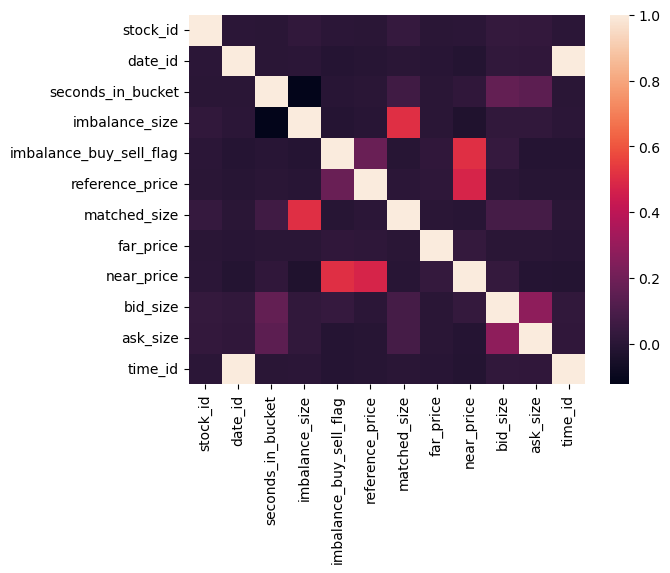

In [7]:
# isolating numerical values
num_vals = df.drop(["row_id"], axis=1)

# creating heatmap
corr_plot = sns.heatmap(num_vals.corr())

In [8]:
num_vals.corr()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_size,ask_size,time_id
stock_id,1.000000e+00,5.028770e-03,-1.116655e-16,0.024639,0.004067,-0.000752,0.035130,-0.000831,0.004736,0.032975,0.027150,0.005029
date_id,5.028770e-03,1.000000e+00,1.280965e-14,0.006441,-0.010572,-0.006456,0.000525,-0.003004,-0.016150,0.024776,0.018673,0.999998
seconds_in_bucket,-1.116655e-16,1.280965e-14,1.000000e+00,-0.123946,-0.003635,-0.000835,0.068625,-0.000550,0.017627,0.162867,0.146338,0.002083
imbalance_size,2.463857e-02,6.441422e-03,-1.239456e-01,1.000000,-0.010159,-0.003717,0.512367,0.000523,-0.030932,0.021141,0.022623,0.006183
imbalance_buy_sell_flag,4.066622e-03,-1.057243e-02,-3.634734e-03,-0.010159,1.000000,0.182100,-0.006003,0.018010,0.508853,0.035238,-0.013352,-0.010580
reference_price,-7.519350e-04,-6.456302e-03,-8.347507e-04,-0.003717,0.182100,1.000000,0.007724,0.015349,0.473595,0.007271,-0.006528,-0.006458
matched_size,3.513044e-02,5.254090e-04,6.862495e-02,0.512367,-0.006003,0.007724,1.000000,-0.000705,-0.002722,0.078554,0.079209,0.000668
far_price,-8.311000e-04,-3.004471e-03,-5.499413e-04,0.000523,0.018010,0.015349,-0.000705,1.000000,0.031519,0.002229,-0.000153,-0.003005
near_price,4.736243e-03,-1.615006e-02,1.762744e-02,-0.030932,0.508853,0.473595,-0.002722,0.031519,1.000000,0.032190,-0.013298,-0.016133
bid_size,3.297499e-02,2.477643e-02,1.628673e-01,0.021141,0.035238,0.007271,0.078554,0.002229,0.032190,1.000000,0.278326,0.025116


In our plot, we noticed some high correlations betweeen:
- near price & reference price: 0.47
- imbalance_buy_sell_flag & reference price: 0.51
- imbalance size & matched size: 0.51

Looking at the correlation heatmap, it is very obvious that we need to do some feature selection on this data when constructing our models. Also, as expected, Target had no correlations with ANY of the features (otherwise there would be no Kaggle competition to begin with).

To begin with we create a simple linear model using the full feature space to act as our baseline

## Baseline Model

In [9]:
# starting by removing NaN values from dataset
# we can try some more complex methods later on
num_vals = num_vals.dropna()
num_vals.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_size,ask_size,time_id
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,19319.31,16149.55,30
5731,1,0,300,242332.96,-1,1.000073,3242054.27,0.981974,0.994490,43205.40,2042.76,30
5732,2,0,300,0.00,0,1.000193,4671376.00,1.000193,1.000193,18971.00,59688.26,30
5733,3,0,300,2914730.16,1,0.999870,41057776.66,1.003870,1.002279,25569.50,37897.50,30
5734,4,0,300,3396923.02,1,0.998496,38356174.88,1.007894,1.007894,14446.00,2601.18,30


In [10]:
# creating test-train split

X = num_vals.drop(["reference_price"], axis = 1)

y = num_vals["reference_price"]

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2)

In [11]:
# creating model with fit
lmod = LinearRegression()
lmod.fit(X_tr,y_tr)

LinearRegression()

In [12]:
# generating predictions
y_hat = lmod.predict(X_tst)

# finding rmse of the baseline model
rmse_baseline = np.sqrt(mean_squared_error(y_tst, y_hat))
print(rmse_baseline)

0.0026446151237004153


In [13]:
# creating feature selection model
bes = SequentialFeatureSelector(LinearRegression(), 
                                direction="forward")

# perfoming model fit
bes.fit(X_tr, y_tr)

# printing optimal feat
pred_bet_feature_set = bes.get_feature_names_out()
print(pred_bet_feature_set)

['seconds_in_bucket' 'imbalance_size' 'imbalance_buy_sell_flag'
 'near_price' 'bid_size']


In [14]:
X_tr_sub = X_tr[pred_bet_feature_set]
X_tst_sub = X_tst[pred_bet_feature_set]

sub_lmod = LinearRegression()

sub_lmod.fit(X_tr_sub,y_tr)

sub_lmod_preds = sub_lmod.predict(X_tst_sub)

# rmse with removed features
rmse_subset = np.sqrt(mean_squared_error(y_tst, sub_lmod_preds))
print(rmse_subset)

0.0026446263828093955


Looking at the RMSE we see above, it appears as though removing these features does not cause any form of increase in the RMSE. Although based on earlier correlation plots, it seems as though more features can be removed from the data.